I'm a big Cornell basketball fan. A few years ago (ca. 2007-2010) this was a lot of fun. These days not so much; Cornell hasn't finished in the top half of its conference since 2010. Part of this is certainly regression to the mean - Cornell going to the Sweet Sixteen (like they did in 2010) was probably a once in a lifetime kind of thing - but the consensus among the fans is that the departure of the old coach, and more to the point, the presence of the new coach, are a big factors in the continuing mediocrity of Cornell basketball. 

I want to see if there's any way to validate (or invalidate) this feeling with some data, so I scraped the game scores and box scores of every college basketball game in the past couple years. There are lots of interesting things to do with this dataset, but first I want to visualize the current rosters of each Ivy League team somehow. Box scores are already in a grid, so a heatmap seems like a good choice. This is where we're headed:

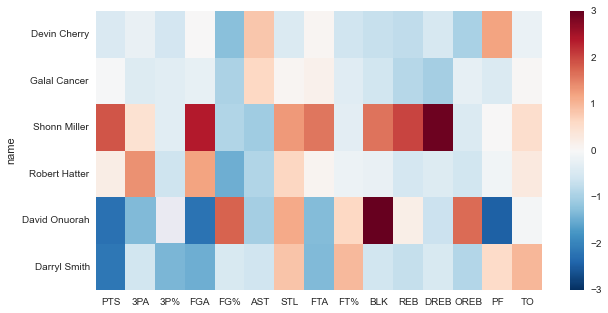

In [51]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
sns.heatmap(players_norm.ix['Cornell'].sort('MIN', ascending=False).head(10).drop('MIN', axis=1),\
            ax=axes, vmin=-3, vmax=3);

First, let's  get the standard imports out of the way:

In [35]:
%matplotlib inline

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Next we'll pull in the raw box score and game score data, and take a look at what each looks like:

In [37]:
# import the raw data
boxes_raw = pd.read_csv('data/2015_box_scores2.csv', sep=',', \
                        encoding='latin-1', skipinitialspace=True)
print(boxes_raw.head(3))

   3PA  3PM  AST  BLK  DREB  FGA  FGM  FTA  FTM  MIN       ...        REB  \
0    0    0    0    1     1    0    0    2    1   13       ...          2   
1    5    2    2    0     6   15    5    6    4   32       ...          8   
2    3    0    1    0     1    3    0    0    0   21       ...          1   

   STL  TO  away    game_ID           name player_ID  position starter  \
0    0   0  True  400585875  Nick Shepherd     51255         F    True   
1    1   5  True  400585875   Chris Thomas     66741         F    True   
2    0   0  True  400585875  Nevin Johnson     56306         G    True   

        team_name  
0  Texas Southern  
1  Texas Southern  
2  Texas Southern  

[3 rows x 23 columns]


In [38]:
games_raw = pd.read_csv('data/2015_game_scores.csv', sep=',', \
                        encoding='latin-1', skipinitialspace=True)
print(games_raw.head(3))

     game_ID        date       away_name      away_record away_half1  \
0  400585875  2014-11-14  Texas Southern  (0-1; 0-1 away)         30   
1  400595560  2014-11-14  Non D-I School              NaN         22   
2  400587365  2014-11-14  Non D-I School              NaN         30   

  away_half2  away_OT  away_final     home_name      home_record home_half1  \
0         32        0          62  E Washington  (1-0; 1-0 home)         32   
1         30        0          52   Sam Houston  (1-0; 1-0 home)         55   
2         22        0          52    E Michigan  (1-0; 1-0 home)         32   

  home_half2  home_OT  home_final  
0         54        0          86  
1         45        0         100  
2         32        0          64  


Since we're going to be normalizing let's choose an appropriate population, i.e. data from Ivy League conference games.

In [39]:
# select ivy league games / box scores (conference games only)
# note that the list is in order of conference standing
ivies = ['Harvard','Yale','Princeton','Dartmouth', \
         'Columbia','Cornell','Brown','Penn']
ivy_games = games_raw.loc[games_raw.home_name.isin(ivies) & \
                          games_raw.away_name.isin(ivies)]
ivy_boxes = boxes_raw.loc[boxes_raw.game_ID.isin(ivy_games.game_ID)]

# generate % statisitcs (FG%, 3P%, FT%)
ivy_boxes['3P%'] = ivy_boxes['3PM'] / ivy_boxes['3PA']
ivy_boxes['FG%'] = ivy_boxes['FGM'] / ivy_boxes['FGA']
ivy_boxes['FT%'] = ivy_boxes['FTM'] / ivy_boxes['FTA']
# replace inf with 0 (for cases with no attempted shots)
ivy_boxes = ivy_boxes.replace([np.inf, -np.inf],0)

/home/jhenri/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jhenri/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jhenri/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.p

Now that we have a subset of the data that only covers the Ivy conference games, time to aggregate and normalize each player's statistics with some quick pandas-fu. First we normalize by average minutes played, then we compute the <a href=https://en.wikipedia.org/wiki/Standard_score>'z-score'</a>. At this point, each entry in a player's statline represents the number of standard deviations his stat is above or below the mean of that stat for the population as a whole (for example, Shonn Miller's DREB stat is 2.92, which means his defensive rebounding is 2.92 standard deviations above the mean). We'll also take this opportunity to clean up the dataframe a little bit by selecting only the columns we want (i.e. the columns corresponding to box score stats).

In [60]:
# minimum average minutes played
MIN_CUTOFF = 10

# generate df with player season averages
players = ivy_boxes.groupby(['team_name','name']).mean()

# just want stats (not starting pct, home vs away %, game_ID)
stats = ['PTS', '3PA', '3P%', 'FGA', 'FG%', 'AST', 'STL', 'FTA', \
         'FT%', 'BLK', 'REB', 'DREB', 'OREB', 'MIN',  'PF', 'TO']
players = players[stats]

# we just want players who averaged at least MIN_CUTOFF min / game
# players with just a few minutes played will throw off the 
# distribution and mess up the normalization
players = players.loc[players['MIN']>MIN_CUTOFF]

# normalize stats per 40 minutes played, then by zscore,
# then reset MIN column
zscore = lambda x: (x - x.mean()) / x.std()
players_norm = players.div(players['MIN'], axis=0)
players_norm = players_norm.apply(zscore)
players_norm['MIN'] = players['MIN']

# invert PF and TO columns, so that 'good' values match 'good' color
players_norm[['PF','TO']] = players_norm[['PF','TO']] * -1

Finally, let's make some heatmaps to visually compare each team's rotation (we'll limit ourselves to the top 8 players per team by average minutes played; players farther down the bench typically haven't played enough to accumulate statistically sound results):

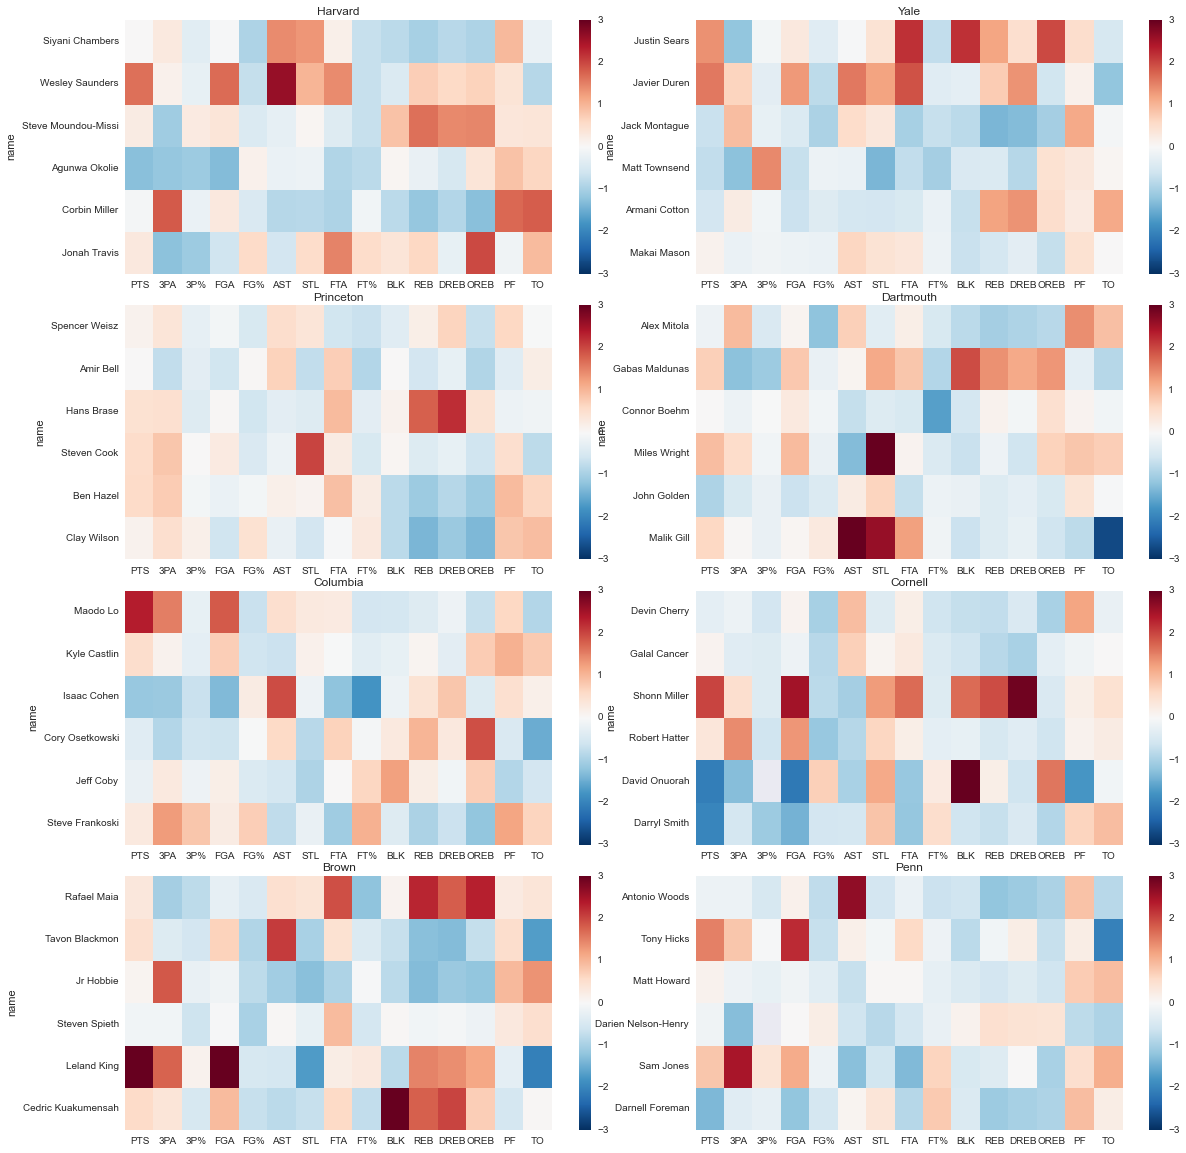

In [61]:
# plot heatmaps for each team
fig, axes = plt.subplots(4,2, figsize=(16,16))
fig.tight_layout()

# flatten the array of array of axes
# think [leaf for tree in forrest for leaf in tree]
axes_flat = [ax for arr in axes for ax in arr]

# plot a heatmap showing, for each stat, how each player's season average compares to the league average
for ax, team in zip(axes_flat, ivies):
    sns.heatmap(players_norm.ix[team].sort('MIN', ascending=False).head(6).drop('MIN', axis=1), \
                ax=ax, vmin=-3, vmax=3)
    ax.set_title(team)

That's an awfully lot of visual information all at once, so let's see if we can break it down and pull out something meaningful. First off, there isn't a clear gradient from best to worst: Penn (last in the league) might be a bit more blue (below the mean) overall than Harvard (first in the league), but it's hard to say for sure. So we can't immediately infer team quality from player quality. (Side note: I'm taking season average statistics to be a proxy for player quality. There are confounding factors, for example players on a team with a well-run offense will have inflated offensive statistics relative to their individual skill levels, but on the whole I think its good enough for a first pass). This does point towards the effect of coaching, as per our original hypothesis. Still, we'll be able to say more concrete things along those lines later, with a more rigorous analysis. 

A few other observations:
- Cornell and Dartmouth both have above average steals (STL) accross the board. I know Cornell typically plays a pressure defense, and a little googling shows that Dartmouth does too. It's nice to see that show up in the data.
- Princeton is very well balanced.
- Shonn Miller (one of Cornell's starting forwards) is a monster. Presumably that's why he's finishing his college career at UConn.

One final observation: it looks like just about everyone is a sub-par shooter, percentage-wise. This seems suspicious, so let's look at the distribution for each of the percentage stats:

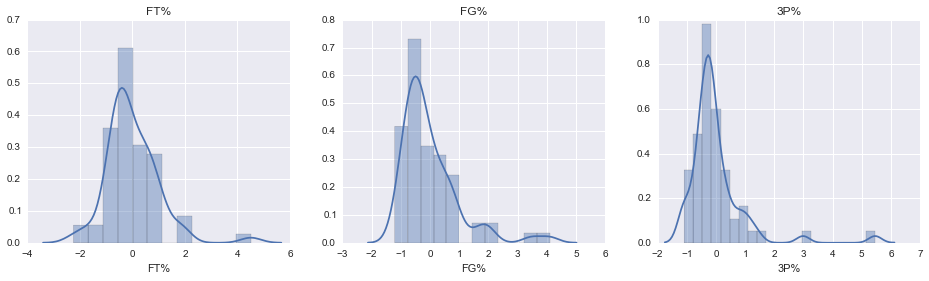

In [62]:
# plot the distributions of each 'percent' stat (FG%, FT%, 3P%)
fig, axes = plt.subplots(1,3, figsize=(16,4))

for ax, stat in zip(axes, ['FT%','FG%','3P%']):
    sns.distplot(players_norm[stat].dropna().order(), ax=ax)
    ax.set_title(stat)

Looks like a few outliers are skewing our percentage distributions, and shifting the mode below zero. Let's have a look at who those outliers are:

In [66]:
# select the top 10 players by 3P%
print(players_norm[['MIN','3P%','3PA']].dropna().sort('3P%', ascending=False).head(10))

                                 MIN       3P%       3PA
team_name name                                          
Brown     Jason Massey     10.500000  5.456531 -1.172227
Princeton Pete Miller      16.857143  2.987737 -1.208654
Yale      Matt Townsend    27.266667  1.431015 -1.234103
Dartmouth Tommy Carpenter  14.928571  1.212292 -1.132942
Penn      Camryn Crocker   11.571429  1.031606 -0.392326
Columbia  Kendall Jackson  10.615385  1.014541  0.480357
          Steve Frankoski  18.083333  0.830811  1.283110
Princeton Henry Caruso     18.785714  0.739592 -0.512969
Yale      Greg Kelley      12.866667  0.690840  1.085452
Columbia  Luke Petrasek    16.250000  0.411725  0.842856


For three-point shooters, the outliers are dominated by players with a negative 3PA stat, i.e. players who took less than the average number of threes and just happened to make a lot of them. (Remember, we took the <a href=https://en.wikipedia.org/wiki/Standard_score>'z-score'</a> for each stat, so each entry is actually the number of standard deviations above or below the mean.) Also, according to this Columbia has three of the four best actual three point shooters (players who take an above average number of threes). Sigh ... I miss <a href=http://espn.go.com/mens-college-basketball/player/_/id/32497/ryan-wittman>Ryan Wittman</a>. 